In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Recopilación de imagenes

## Seleccionar imagenes

### Descripción del código
- Se carga localmente el archivo "classes.csv", que contiene información como las rutas de las imágenes, tamaños y otros datos relevantes, y se convierte en un DataFrame de pandas.
  
- A partir de dicho DataFrame, se extrae una muestra aleatoria de 10 valores, a la que denominamos ***sample***, y se establece el parámetro ***random_state=42*** para garantizar la replicabilidad del proceso.
  
> Nota: random_state=42 se utilizara en varias ocaciones para garantizar la replicabilidad.

### Anotaciones
- Se busca extraer una muestra representativa del conjunto de datos, por lo que se utilizan funciones que faciliten la selección de muestras completamente aleatorias.

In [2]:
df = pd.read_csv("classes.csv") # Cargar archivo
sample_df = df.sample(n=10, random_state=42) # Seleccionar muestra de 10 valores aleatorios
sample_df

,filename,artist,genre,description,phash,width,height,genre_count,subset
53644,Rococo/william-hogarth_central-panel-of-the-al...,william hogarth,['Rococo'],central-panel-of-the-altar-triptych-w-st-nicho...,afc495b5024bad4e,1382,1594,1,train
46852,Realism/isaac-levitan_view-of-nizhniy-novgorod...,isaac levitan,['Realism'],view-of-nizhniy-novgorod,c7f87c0f70f40338,2053,1381,1,train
5047,Art_Nouveau_Modern/raphael-kirchner_marionette...,raphael kirchner,['Art Nouveau Modern'],marionettes-3,ae60261e31deb19b,1382,2200,1,train
662,Abstract_Expressionism/helen-frankenthaler_acr...,helen frankenthaler,['Abstract Expressionism'],acres-1959,84717cceccc9c7e0,1406,1382,1,train
55259,Romanticism/fyodor-bronnikov_portrait-of-a-gir...,fyodor bronnikov,['Romanticism'],portrait-of-a-girl-evdokia-kuznetsova-1842,989c6667619b9ac3,1382,1900,1,train
7149,Baroque/gian-lorenzo-bernini_st-longinus(1).jpg,gian lorenzo bernini,['Baroque'],st-longinus(1),e8a596919bce4f88,1382,1577,1,train
35942,Northern_Renaissance/hans-holbein-the-younger_...,hans holbein the younger,['Northern Renaissance'],portrait-of-philipp-melanchthon,ce62b11c1d419e9f,2446,1381,1,train
1696,Abstract_Expressionism/sam-francis_indigo-wood...,sam francis,['Abstract Expressionism'],indigo-wood-1982,affe080285b9ec9c,1382,1666,1,train
43687,Realism/aleksey-savrasov_bonfire-of-the-river.jpg,aleksey savrasov,['Realism'],bonfire-of-the-river,98e366181f07e379,1382,1591,1,train
34663,Naive_Art_Primitivism/william-h.-johnson_farm-...,william h. johnson,['Naive Art Primitivism'],farm-family-1940,faa8e5b9909483d6,1382,1783,1,train


In [11]:
sample_df["filename"]

53644    Rococo/william-hogarth_central-panel-of-the-al...
46852    Realism/isaac-levitan_view-of-nizhniy-novgorod...
5047     Art_Nouveau_Modern/raphael-kirchner_marionette...
662      Abstract_Expressionism/helen-frankenthaler_acr...
55259    Romanticism/fyodor-bronnikov_portrait-of-a-gir...
7149       Baroque/gian-lorenzo-bernini_st-longinus(1).jpg
35942    Northern_Renaissance/hans-holbein-the-younger_...
1696     Abstract_Expressionism/sam-francis_indigo-wood...
43687    Realism/aleksey-savrasov_bonfire-of-the-river.jpg
34663    Naive_Art_Primitivism/william-h.-johnson_farm-...
Name: filename, dtype: object

## Vizualizar las imagenes seleccionadas

### Descripción del código

- Se genera una figura con 10 subgráficos (plt.subplots(1, 10)) de un tamaño de (15, 5).
- Se extraen los nombres de las imagenes desde ***sample["filename"]***.
- Se recorre cada subgráfico (ax) y su respectiva imagen (img_path).
- Se lee la imagen con OpenCV (cv2) y se convierte de BGR a RGB.
- Se muestran las imagenes.


### Anotaciones

- La conversión de imagenes de BGR a RGB, es debido a que OpenCV (cv2) carga las imagenes en formato BGR, y matplotlib lee imagenes en formato RGB.
  
> Nota: este proceso de conversión de imagenes se repetirá en varias ocasiones.

- Al mostrar las imagenes en pantalla, podemos asegurarnos que no hubo problema en la carga de las mismas, además tendremos certeza con cuales imagenes estamos trabajando.


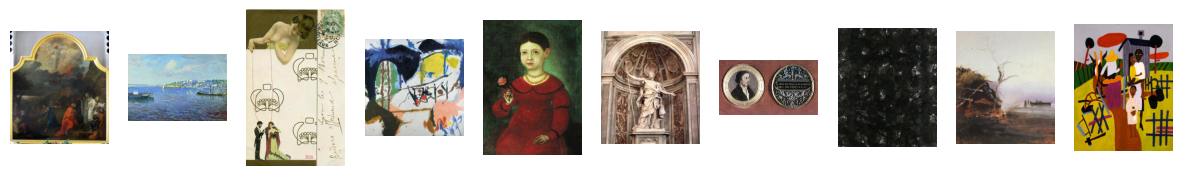

In [15]:
fig, axs = plt.subplots(1, 10, figsize=(15, 5)) # Dimensiones del grafico
images = sample_df["filename"] # Rutas de imagenes

for ax, img_path in zip(axs, images):
    path = "archive/" + img_path #imagen
    img = cv2.imread(path)  # Cargar imagen
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
    ax.imshow(img)
    ax.axis("off") # Oculta los ejes de las imagenes

plt.show()

# Preparación de imagenes

## Procesar imagenes

### Descripción del código

- La función ***load_and_preprocess_image*** se aplica a todas las imágenes, y su propósito es cargar la imagen con OpenCV (cv2), convertirla de BGR a RGB, redimensionarla al tamaño definido ***(300, 300)***, y convertirla en una matriz de píxeles. Luego, normaliza los valores de los píxeles (de 0 a 1) dividiéndolos entre 255. Finalmente, retorna la matriz, que es almacenada en la lista ***processed_images***.
  
- A continuación, se crea una figura con dos subgráficos utilizando plt.subplot(1, 2, 1) y plt.subplot(1, 2, 2). En el primer subgráfico se muestra la imagen original, mientras que en el segundo se presenta la imagen preprocesada, ya con su tamaño ajustado y los valores normalizados.

### Anotaciones

- Redimencionamos la imagen a (300, 300) por diferentes motivos como la reducción de complejidad computacional, consistencia en el tamaño de entrada para el modelo, entre otras.
  
- Con ***img.reshape***, la imagen que es una matriz de píxeles con dimensiones (300, 300, 3), se convierte en una matriz de tamaño (90000, 3). Esto crea una lista de píxeles donde cada fila representa un píxel con sus valores RGB y nos facilita la manipulación.

- La normalización de valores de 0 a 1 es util cuando se entren algunos tipo de modelos, en este caso lo utilizamos como estandar.

In [ ]:
images.iloc

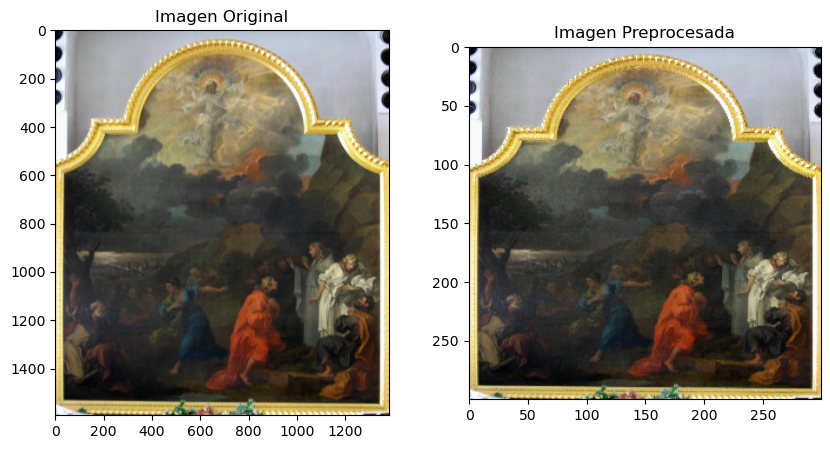

In [41]:
# Tamaño estándar para redimensionar las imágenes
IMG_SIZE = (300, 300)  

def load_and_preprocess_image(image_path):
    """Carga y preprocesa una imagen"""
    path = "archive/" + image_path
    img = cv2.imread(path)  # Cargar imagen
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
    img = cv2.resize(img, IMG_SIZE)  # Redimensionar imagen 
    img_array = img.reshape(-1, 3)  # Convertir a una matriz de (90000, 3)
    img_array = img_array / 255.0  # Normalizar valores (0 a 1)
    return img_array

# Imagenes procesadas
processed_images = [load_and_preprocess_image(img) for img in images]

# Mostrar una imagen original
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread("archive/" + images.iloc[0])[..., ::-1])  # Imagen original
plt.title("Imagen Original")

# Mostrar una imagen preprocesada
plt.subplot(1, 2, 2)
plt.imshow(processed_images[0].reshape(IMG_SIZE[0], IMG_SIZE[1], 3))  # Imagen preprocesada
plt.title("Imagen Preprocesada")
plt.show()


# Probando diferentes modelos 

## Uso del modelo k-Means

### Descripción del código

- Se aplica la función ***extract_colors_kmeans*** a una imagen previamente procesada, la cual utiliza el algoritmo K-Means para extraer 7 colores (n_colors=7) a partir de un conjunto de píxeles (estos píxeles corresponden a las imágenes procesadas en matrices de dimenciones (90000, 3). Esta función retorna los ***kmeans.cluster_centers***, que representan los colores dominantes y ***kmeans.labels_***, que indica a qué clúster pertenece cada píxel.

> Nota: kmeans.labels_ se usara más adelante para probar la eficiencia del modelo.
  
- Finalmente, se muestra la paleta de colores de la imagen selecionada.

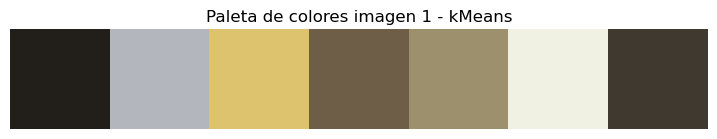

In [19]:
def extract_colors_kmeans(pixels, n_colors=5):

    # Aplicar K-Means
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(pixels)

    return kmeans.cluster_centers_, kmeans.labels_

kmeans_colors, kmeans_labels = extract_colors_kmeans(processed_images[0], n_colors=7)

# Mostrar los colores extraídos
plt.figure(figsize=(9, 2))
plt.imshow([kmeans_colors]) 
plt.axis("off")
plt.title("Paleta de colores imagen 1 - kMeans")
plt.show()

## Uso del modelo MeanShift

- Se aplica la función ***extract_colors_meanshift*** a una imagen previamente procesada, la cual calcula automáticamente el ancho de banda óptimo para el agrupamiento utilizando una muestra de 500 píxeles con estimate_bandwidth. A continuación, se inicializa el algoritmo MeanShift con el ancho de banda estimado y se extraen los colores. Esta función retorna los ***meanshift.cluster_centers***, que representan los colores dominantes y ***meanshift.labels_***, que indica a qué clúster pertenece cada píxel.
  
> Nota: meanshift.labels_ se usara más adelante para probar la eficiencia del modelo.
  
- Finalmente, se muestra la paleta de colores de la imagen selecionada.

> ***Nota: el siguiente código puede demorar más de 1 hora ejecutandose.***

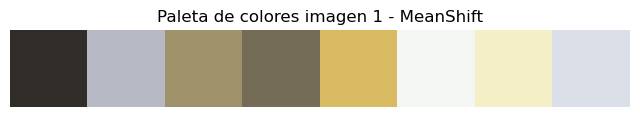

In [16]:
def extract_colors_meanshift(pixels):

    # Estimación automática del parámetro de ancho de banda
    bandwidth = estimate_bandwidth(pixels, quantile=0.1, n_samples=500)

    # Aplicar MeanShift
    meanshift = MeanShift(bandwidth=bandwidth)
    meanshift.fit(pixels)

    return meanshift.cluster_centers_ , meanshift.labels_

meanshift_colors, meanshift_labels = extract_colors_meanshift(processed_images[0])

# Mostrar los colores extraídos
plt.figure(figsize=(8, 2))
plt.imshow([meanshift_colors ])
plt.axis("off")
plt.title("Paleta de colores imagen 1 - MeanShift")
plt.show()


## Uso del modelo DBSCAN

### Descripción del código

- Se aplica la función ***extract_colors_dbscan*** a dos imagenes previamente procesadas, la cual inicializa el algoritmo DBSCA con parametros eps y min_samples previamente definidos, se identifican los clusters detectados (colores) ignorando el ruido (-1). Esta función retorna los ***colors***, que representan los colores dominantes y ***labels***, que indica a qué clúster pertenece cada píxel.
  
> Nota: labels se usara más adelante para probar la eficiencia del modelo.

- Se muestra la paleta de colores de la imagen selecionada.

### Anotaciones

- El parámetro de "radio de vecindad" o ***eps*** utilizado en DBSCAN. Controla cuán cercanos deben estar los puntos entre sí para ser considerados parte del mismo clúster.

- El parametro ***min_samples*** número mínimo de puntos requeridos para formar un clúster. El valor predeterminado es 10.

- La variable ***colors*** se calcula recorriendo todos los clústeres que no corresponden a -1 (ruido). Luego, se recorre cada fila de la matriz (de tamaño 9000 x 3) para identificar a qué clúster pertenece. Con los datos obtenidos, se calcula un promedio que representa el color de cada clúster.

In [ ]:
def extract_colors_dbscan(pixels, eps=15, min_samples=10):
    
    # Aplicar DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(pixels)
    
    # Obtener los clusters detectados (excluyendo ruido)
    unique_labels = set(labels)
    colors = np.array([pixels[labels == l].mean(axis=0) for l in unique_labels if l != -1])  # Ignorar ruido (-1) y promediar los clusters
    return colors, labels


dbscan_colors, dbscan_labels = extract_colors_dbscan(processed_images[0], eps=2, min_samples=50)

# Mostrar los colores extraídos
plt.figure(figsize=(8, 2))
plt.imshow([dbscan_colors])  # Mostrar como paleta de colores
plt.axis("off")
plt.title("Paleta de colores imagen 1 - DBSCAN")
plt.show()

dbscan_colors2, dbscan_labels2 = extract_colors_dbscan(processed_images[1], eps=0.023, min_samples=50)

# Mostrar los colores extraídos
plt.figure(figsize=(8, 2))
plt.imshow([dbscan_colors2])  # Mostrar como paleta de colores
plt.axis("off")
plt.title("Paleta de colores imagen 2 - DBSCAN")
plt.show()


## Evaluar modelos con Silhouette Score

In [62]:
def evaluate(pixels, labels):
    
    score = silhouette_score(pixels, labels)
    return score

# Evaluar con modelos
print(f"Silhouette Score para modelo KMeans: {evaluate(processed_images[0], kmeans_labels)}")
print(f"Silhouette Score para modelo MeanShift: {evaluate(processed_images[0], meanshift_labels)}")
print(f"Silhouette Score para modelo DBSCAN: {evaluate(processed_images[0], dbscan_labels)}")


Silhouette Score para modelo KMeans: 0.4441897530974956
Silhouette Score para modelo MeanShift: 0.49281756312582947
Silhouette Score para modelo DBSCAN: -0.5214214296747864


# Selección del modelo

## Caracteristicas


| Algoritmo   | Características                                                                 |
|-------------|----------------------------------------------------------------------------------|
| **K-Mens**  | - Permite definir el número de clusters.                                         |
|             | - Es rápido.                                                                     |
|             | - Rango positivo de agrupamiento según Silhouette Score.                         | 
| **MeanShift**| - Intenta detectar el número óptimo de clusters.                                 |
|             | - Es lento y consume muchos recursos.                                            |
|             | - Sensible al parámetro de bandwidth.                                            |
|             | - Rango positivo de agrupamiento según Silhouette Score.                         |
| **DBSCAN**  | - Filtra el ruido de los datos.                                                  |
|             | - Sensible al parámetro eps.                                                    |
|             | - El número de clusters depende de su parametrización.                          |
|             | - Rango negativo de agrupamiento según Silhouette Score.                        |


# Debido a su eficiencia y la facilidad de definir cuantos clusters se necesitan, el modelo que se elige en este caso es K-Mens

# Colores en 2D t-SNE y PCA

Definir las funciones que se utilizaran para representar los colores en 2D. Una funcion para t-SNE y otra para PCA 

> ***Nota: el siguiente código puede demorar más de 10 minutos ejecutandose.***

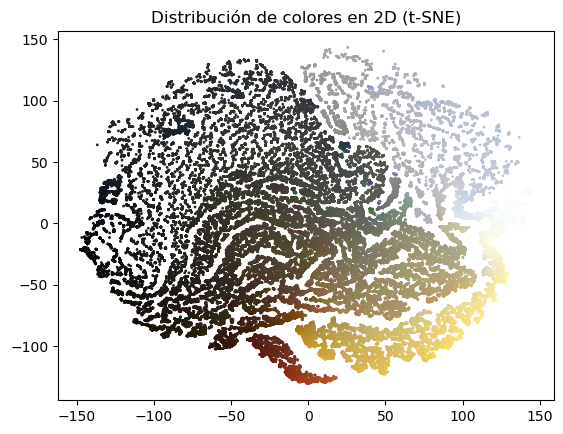

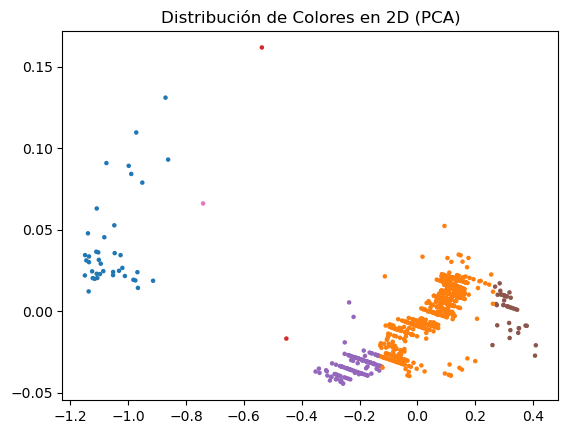

In [42]:
def visualize_colors_2d_tsne(pixels):
    """Visualiza la distribución de los colores usando t-SNE."""
    tsne = TSNE(n_components=2, random_state=42)
    transformed = tsne.fit_transform(pixels)

    return transformed, pixels

tsne_transformed, tsne_pixels  = visualize_colors_2d_tsne(processed_images[0])

plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=tsne_pixels, s=1)
plt.title("Distribución de colores en 2D (t-SNE)")
plt.show()

def visualize_colors_2d_pca(pixels):
    pca = PCA(n_components=2)
    transformed = pca.fit_transform(pixels[:1000])

    return transformed, pixels

colors_image_test_pca, labels_image_test_pca = extract_colors_kmeans(processed_images[0], n_colors=7)
pca_transformed, pca_pixels  = visualize_colors_2d_pca(processed_images[0])

plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=[plt.cm.tab10(i) for i in labels_image_test_pca[:1000]], s=5)
plt.title("Distribución de Colores en 2D (PCA)")
plt.show()

# Resultado final con colores en 2D t-SNE

> ***Nota: el siguiente código puede demorar más de 1 hora ejecutandose.***

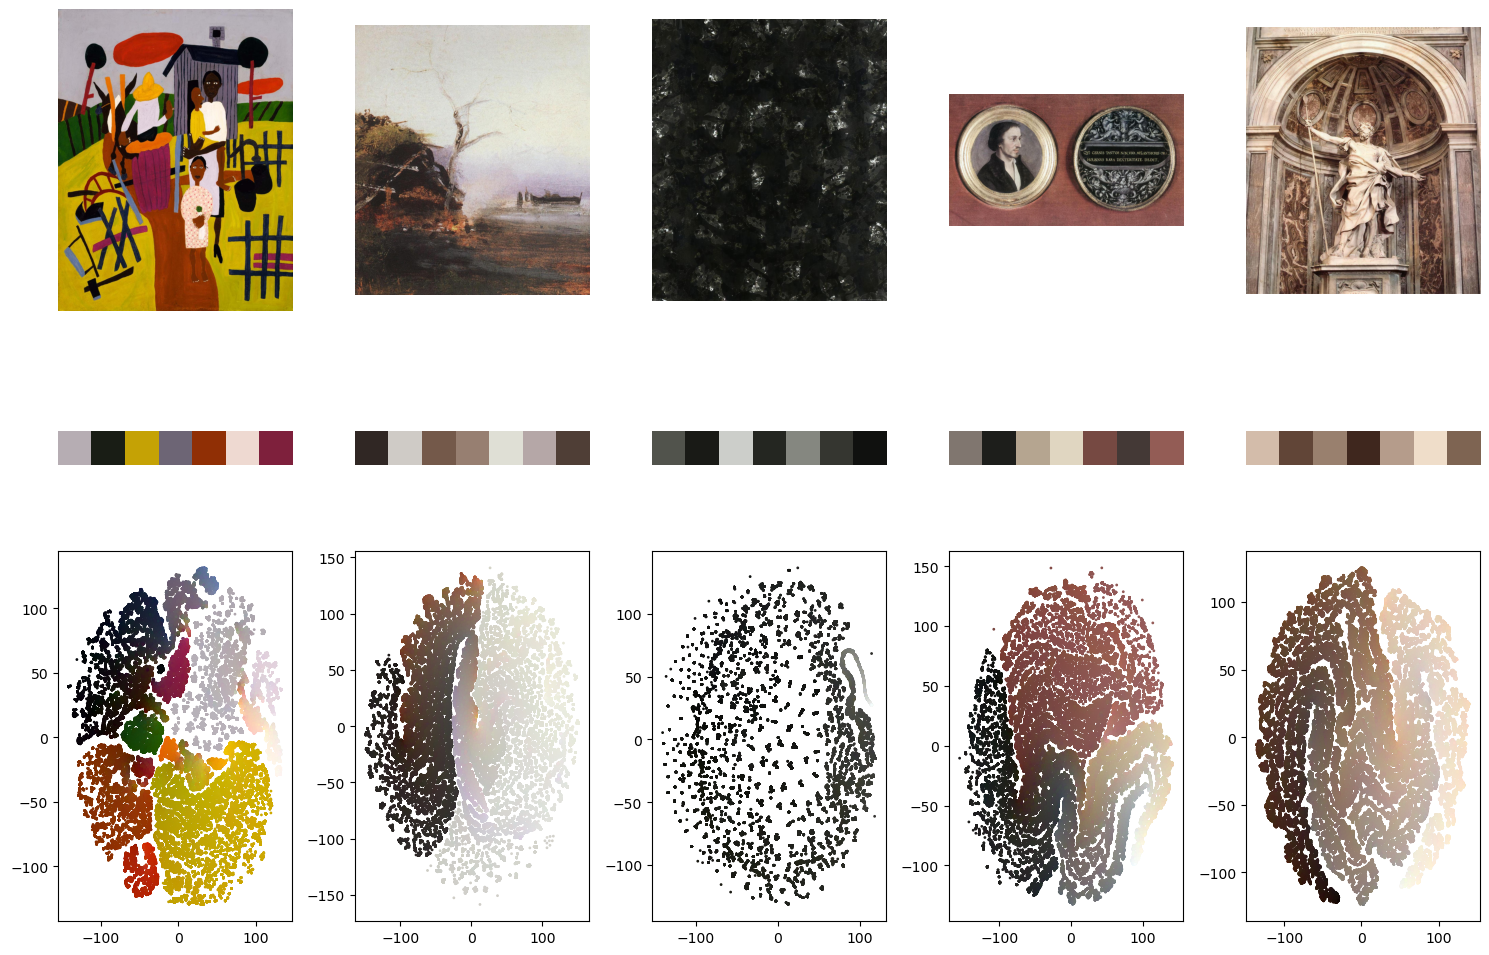

In [44]:
# Crear figura con 3 filas y 5 columnas
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

# Primera fila (Imagenes)
for i in range(5):
    path = "archive/" + images.iloc[-(i+1)] #imagen
    img = cv2.imread(path)  # Cargar imagen
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
    axs[0, i].imshow(img)
    axs[0, i].axis("off")


# Segunda fila (Paleta)
for i in range(5):
    colors, labels = extract_colors_kmeans(processed_images[-(i+1)], n_colors=7)
    axs[1, i].imshow([colors]) 
    axs[1, i].axis("off")

# Tercera fila (Imagen 2D)
for i in range(5):
    transformed, pixels = visualize_colors_2d_tsne(processed_images[-(i+1)])
    axs[2, i].scatter(transformed[:, 0], transformed[:, 1], c=pixels, s=1)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Resultado final con colores en 2D PCA

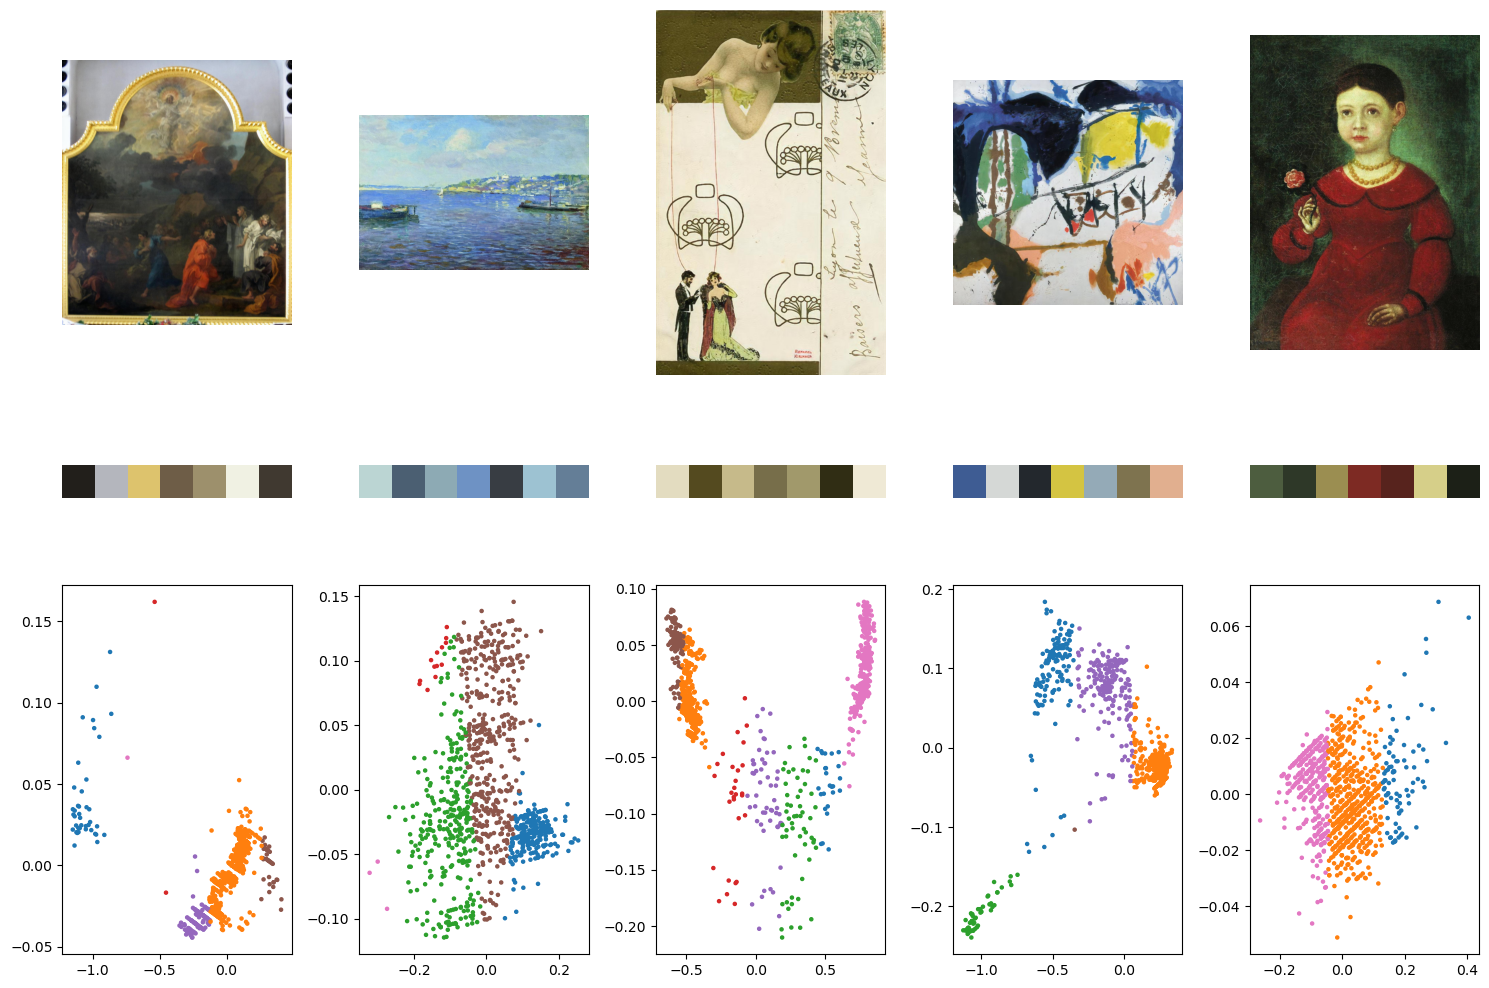

In [452]:
# Crear figura con 3 filas y 5 columnas
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

# Primera fila (Imagenes)
for i in range(5):
    path = "archive/" + images.iloc[i] #imagen
    img = cv2.imread(path)  # Cargar imagen
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
    axs[0, i].imshow(img)
    axs[0, i].axis("off")


# Segunda fila (Paleta) y tercera fila (imagen 2d)
for i in range(5):
    colors, labels = extract_colors_kmeans(processed_images[i], n_colors=7)
    axs[1, i].imshow([colors]) 
    axs[1, i].axis("off")

    transformed, pixels = visualize_colors_2d_pca(processed_images[i])
    axs[2, i].scatter(transformed[:, 0], transformed[:, 1], c=[plt.cm.tab10(i) for i in labels[:1000]], s=5)
    

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()